# Natural Language Processing

## Word2Vec (Negative Sampling)

Let's work on negative-sampling based implementation of word2vec.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

## 1. Define some very simple data for understanding

In [2]:
corpus = ["apple banana ice", "banana orange fruit", "orange ice fruit", "orange grapes fruit", "banana ice fruit", "grapes fruit ice", 
          "dog cat animal", "cat monkey animal", "monkey dog animal", "conda dog animal", "monkey dog conda", "monkey conda animal"]

In [3]:
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'ice'],
 ['banana', 'orange', 'fruit'],
 ['orange', 'ice', 'fruit'],
 ['orange', 'grapes', 'fruit'],
 ['banana', 'ice', 'fruit'],
 ['grapes', 'fruit', 'ice'],
 ['dog', 'cat', 'animal'],
 ['cat', 'monkey', 'animal'],
 ['monkey', 'dog', 'animal'],
 ['conda', 'dog', 'animal'],
 ['monkey', 'dog', 'conda'],
 ['monkey', 'conda', 'animal']]

In [4]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['ice',
 'banana',
 'monkey',
 'cat',
 'grapes',
 'dog',
 'orange',
 'conda',
 'animal',
 'apple',
 'fruit']

In [5]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'ice': 0, 'banana': 1, 'monkey': 2, 'cat': 3, 'grapes': 4, 'dog': 5, 'orange': 6, 'conda': 7, 'animal': 8, 'apple': 9, 'fruit': 10}


In [6]:
#vocab size
voc_size = len(vocab)
print(voc_size)

11


## 2. Prepare train data

In [7]:
for c in corpus:
    print(c)

['apple', 'banana', 'ice']
['banana', 'orange', 'fruit']
['orange', 'ice', 'fruit']
['orange', 'grapes', 'fruit']
['banana', 'ice', 'fruit']
['grapes', 'fruit', 'ice']
['dog', 'cat', 'animal']
['cat', 'monkey', 'animal']
['monkey', 'dog', 'animal']
['conda', 'dog', 'animal']
['monkey', 'dog', 'conda']
['monkey', 'conda', 'animal']


In [8]:
def random_batch(batch_size, word_sequence):
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    # here we NOT gonna make input; we shall learn the embedding ourself
    # we cannot train using taking integer as input...
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

### Testing the method

In [9]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ",  input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[1]
 [5]]
Target:  [[9]
 [7]]


## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [10]:
Z = 0.001

In [11]:
from collections import Counter

word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])

In [12]:
word_count[',']

0

In [13]:
num_total_words

36

In [14]:
unigram_table = []

for vo in vocab:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [15]:
Counter(unigram_table)

Counter({'ice': 192,
         'banana': 155,
         'monkey': 192,
         'cat': 114,
         'grapes': 114,
         'dog': 192,
         'orange': 155,
         'conda': 155,
         'animal': 227,
         'apple': 68,
         'fruit': 227})

### Negative Sampling

In [16]:
import random
from torch.autograd import Variable

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else 999, seq))
    return Variable(torch.LongTensor(idxs))

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    
    return torch.cat(neg_samples)

### Testing the negative sampling

In [17]:
input_batch = torch.Tensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [18]:
target_batch.shape

torch.Size([2, 1])

In [19]:
num_neg = 3
negative_sampling(target_batch, unigram_table, num_neg)

#{'grapes': 0, 'apple': 1, 'animal': 2, 'cat': 3, 'ice': 4, 'orange': 5, 'dog': 6, 'monkey': 7, 'conda': 8, 'fruit': 9, 'banana': 10}

tensor([[5, 7, 6],
        [8, 9, 5]])

In [20]:
target_batch[1]

tensor([7])

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [21]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, projection_dim):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, projection_dim) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, projection_dim) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        negative_score = torch.sum(neg_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2), 1).view(neg_embeds.size(0), -1) # BxK -> Bx1
        #[batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1] = [batch_size, k] ==sum==> [batch_size, 1]
        
        loss = self.logsigmoid(positive_score) + self.logsigmoid(negative_score)
        
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

## 5. Training

In [22]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = SkipgramNegSampling(voc_size, embedding_size)
num_neg        = 10 # num of negative sampling

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Training
num_epochs = 5000
for epoch in range(num_epochs):
    input_batch, target_batch = random_batch(batch_size, corpus)
    
    #input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch)
    
    #target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)
    
    #negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    
    optimizer.zero_grad()
        
    loss = model(input_batch, target_batch, negs_batch)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))


Epoch: 1000 cost = 2.453739
Epoch: 2000 cost = 0.824481
Epoch: 3000 cost = 1.099436
Epoch: 4000 cost = 1.014254
Epoch: 5000 cost = 0.802103


## 6. Plotting the embeddings

In [24]:
#list of vocabs
vocab[:10]

['ice',
 'banana',
 'monkey',
 'cat',
 'grapes',
 'dog',
 'orange',
 'conda',
 'animal',
 'apple']

In [25]:
word = vocab[0]

In [26]:
#numericalization
id = word2index[word]
id

0

In [27]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [28]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.8408,  0.1699]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.8436, -0.0344]], grad_fn=<EmbeddingBackward0>))

In [29]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.0677, grad_fn=<SelectBackward0>)

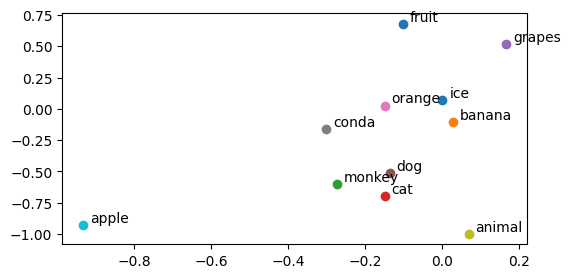

In [30]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    
    x, y = word_embed[0][0].item(), word_embed[0][1].item()
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

Using what we learn in the previous class, try to calculate the cosine similarity between two words!